# Spring 2023 AI506 Term Project Task 2: Outfit Generation
<b>Contributor</b>: Bryan Nathanael Wijaya, 20200735, bryannwijaya@kaist.ac.kr, School of Electrical Engineering, KAIST   
<b>Team Member</b>: Quang Minh Nguyen, 20200854, qm.nguyen@kaist.ac.kr, School of Electrical Engineering, KAIST  
<b>Instructor</b>: Prof. Kijung Shin, Kim Jaechul Graduate School of AI, KAIST  

Fashion outfit recommendations have attracted more and more attention, helping people buy clothes conveniently from a wide range of choices. In the online fashion community, people browse through fashion items and fashion outfits, sets of fashion items that match each other appropriately. By utilizing the user’s preference and outfit affiliation information jointly and fully, in this task, we aim to <b>predict one missing fashion item in an incomplete unseen outfit and complete it</b>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm

from collections import defaultdict
import itertools
import random
import re
import time
import random

## Step 1. Uploading user-item interactions `ui`, training data `train`, validation queries `val_query`, validation ground-truth answers `val_truth`, and test queries `test_query`

### Step 1-1. User-item interactions `ui`

In [2]:
ui = defaultdict(list)

cnt = 0
with open("./dataset/user_item.csv", "r") as f:
    for line in f:
        _line = list(map(int, line.rstrip().split(",")))
        ui[_line[0]].append(_line[1])
        cnt += 1

In [3]:
if cnt == 2290645:
    print(f"User-item interaction data uploaded correctly.\nTotal number of distinct users: {len(ui)}")

User-item interaction data uploaded correctly.
Total number of distinct users: 53843


### Step 1-2. Training data `train`

In [4]:
train = defaultdict(list)

cnt = 0
with open(f"./dataset/itemset_item_training.csv", "r") as f:
    for line in f:
        _line = list(map(int, line.rstrip().split(",")))
        train[_line[0]].append(_line[1])
        cnt += 1

In [5]:
if cnt == 85822 and len(train) == 22156:
    print("Training data uploaded correctly.")

Training data uploaded correctly.


### Step 1-3. Validation queries `val_query`

In [6]:
val_query = defaultdict(list)

cnt = 0
with open(f"./dataset/itemset_item_valid_query.csv", "r") as f:
    for line in f:
        _line = list(map(int, line.rstrip().split(",")))
        val_query[_line[0]].append(_line[1])
        cnt += 1

In [7]:
if cnt == 7797 and len(val_query) == 2769:
    print("Validation queries uploaded correctly.")

Validation queries uploaded correctly.


### Step 1-4. Validation ground-truth answers `val_truth`

In [8]:
val_truth = defaultdict(list)

cnt = 0
with open(f"./dataset/itemset_item_valid_answer.csv", "r") as f:
    for line in f:
        _line = list(map(int, line.rstrip().split(",")))
        val_truth[_line[0]].append(_line[1])
        cnt += 1

In [9]:
if cnt == 2769 and len(val_truth) == 2769:
    print("Validation ground-truth answers uploaded correctly.")

Validation ground-truth answers uploaded correctly.


### Step 1-5. Test queries `test_query`

In [10]:
test_query = defaultdict(list)

cnt = 0
with open(f"./dataset/itemset_item_test_query.csv", "r") as f:
    for line in f:
        _line = list(map(int, line.rstrip().split(",")))
        test_query[_line[0]].append(_line[1])
        cnt += 1

In [11]:
if cnt == 7759 and len(test_query) == 2769:
    print("Test queries uploaded correctly.")

Test queries uploaded correctly.


## Step 2. Functions for calculating the average accuracy and average rank in the validation set
For each query itemset and its list of predicted candidate items for the missing item, we define the accuracy and ranking as follows:
$$Accuracy = \begin{cases}
1, & \text{if the missing item (i.e., ground-truth) is included in the prediction list}\\
0, & \text{otherwise}
\end{cases}$$
$$Rank = \begin{cases}
\text{rank(ground-truth)}, & \text{if the missing item (i.e., ground-truth) is included in the prediction list}\\
101, & \text{otherwise}
\end{cases}$$

In [12]:
# calculates the average accuracy of our model based on the above definition over the whole validation set
def accuracy(val_pred, val_truth):
    accuracy = 0
    for pred_key, pred, truth_key, truth in zip(val_pred.keys(), val_pred.values(), val_truth.keys(), val_truth.values()):
        assert pred_key == truth_key and type(truth) == list and type(pred) == list and len(truth) == 1 and len(pred) == 100
        if truth[0] in pred:
            accuracy += 1
    average = accuracy / len(val_pred)
    return average

In [13]:
# calculates the average rank of our model based on the above definition over the whole validation set
def rank(val_pred, val_truth):
    rank = 0
    for pred_key, pred, truth_key, truth in zip(val_pred.keys(), val_pred.values(), val_truth.keys(), val_truth.values()):
        assert pred_key == truth_key and type(truth) == list and type(pred) == list and len(truth) == 1 and len(pred) == 100
        if truth[0] in pred:
            rank += (pred.index(truth[0]) + 1)  # assume rank starts from 1 and ends at 100
        else:
            rank += 101
    average = rank / len(val_pred)
    return average

In [14]:
def evaluate(val_pred, val_truth):
    accuracy_avg = accuracy(val_pred, val_truth)
    rank_avg = rank(val_pred, val_truth)
    print(f"Average accuracy in the validation set: {accuracy_avg}")
    print(f"Average rank in the validation set:     {rank_avg}")
    return accuracy_avg, rank_avg

## Step 3. Baseline: Random Guessing

In [ ]:
# get the items in the train data 
items = {}
for i in train.keys():
    iter = train[i]
    for elem in iter:
        try:
            items[elem] += 1
        except:
            items[elem] = 1

items_ = [elem[0] for elem in items.items()]

In [ ]:
# return 100 random items for each itemset
val_pred = {}
for i in val_query.keys():
    val_pred[i] = random.sample(items_, 100)

In [ ]:
# evaluate model
evaluate(val_pred, val_truth)

Average accuracy in the validation set: 0.001444564824846515
Average rank in the validation set:     100.9534127843987


(0.001444564824846515, 100.9534127843987)

## Step 4. Baseline: Frequent items

In [ ]:
# get the items in the train data 
items = {}
for i in train.keys():
    iter = train[i]
    for elem in iter:
        try:
            items[elem] += 1
        except:
            items[elem] = 1

items_ = [elem[0] for elem in items.items()]

In [ ]:
# sort items based on their frequency in the train data (descending order)
items_ = sorted(items.items(), key=lambda x:x[1], reverse=True)
items_ = [elem[0] for elem in items_]

In [ ]:
# return the 100 most frequent items as the query result for all itemsets
val_pred = {}
recom = items_[:100]
for i in val_query.keys():
    val_pred[i] = recom

In [ ]:
# evaluate model
evaluate(val_pred, val_truth)

Average accuracy in the validation set: 0.11664860960635609
Average rank in the validation set:     93.40953412784398


### What if we slightly modify the recommendation to not include the items that are already in the itemset?

In [ ]:
# return the 100 most frequent items as the query result for all itemsets, excluding items that are already in the itemset
val_pred = {}
for i in val_query.keys():
    iter = val_query[i]
    val_pred[i] = [elem for elem in items_ if elem not in iter][:100]

In [ ]:
# evaluate model
evaluate(val_pred, val_truth)

Average accuracy in the validation set: 0.11700975081256772
Average rank in the validation set:     93.38786565547129


## Step 5. Approach 1: Itemset-itemset collaborative filtering
<b>Best result: wt=0.02, rt=0.00</b>  
Average accuracy: 0.18273745034308414  
Average rank:     87.79920548934633

### Step 5-1. Itemset-itemset collaborative filtering with ```train``` dataset

In [29]:
# calculate the similarity between two itemsets, foo and boo
def similarity(foo, boo):
    sim = 0
    for i in range(len(foo)):
        for j in range(len(boo)):
            if foo[i] == boo[j]:
                sim += 1
    return sim

In [30]:
# sort the itemsets in train in the order of similarity to the itemset foo
def most_similar(foo, wt=0, limit=False):
    sims = []
    for i in train.keys():
        sim = similarity(foo, train[i]) + wt
        if not limit or sim > 0:
            sims.append((i, sim))
    sims.sort(key=lambda x:x[1], reverse=True)
    return sims

In [31]:
# get the items in the train data 
items = {}
for i in train.keys():
    iter = train[i]
    for elem in iter:
        try:
            items[elem] += 1
        except:
            items[elem] = 1

items_ = [elem[0] for elem in items.items()]

# sort items based on their frequency in the train data (descending order)
frequents = sorted(items.items(), key=lambda x:x[1], reverse=True)
frequents = [elem[0] for elem in frequents]

In [32]:
# predicts the 100 most probable missing item in each itemset in dest_query
def model(dest_query, wt=0, frequent=False):
    dest_pred = {}
    # for each itemset in dest_query
    for i in tqdm(dest_query.keys()):
        iter = dest_query[i]
        # sort the itemsets in train in the order of similarity to the itemset
        sims = most_similar(iter, wt, limit=frequent)
        candidates = {}
        # for each itemset in sims
        for j in range(len(sims)):
            iter_ = train[sims[j][0]]
            sim_ = sims[j][1]
            # append each item in it together with the similarity of this sims itemset to the dest_query itemset of interest
            for k in range(len(iter_)):
                # only if this item is not already in the dest_query itemset itself
                if iter_[k] not in iter:
                    try:
                        candidates[iter_[k]] += sim_
                    except:
                        candidates[iter_[k]] = sim_
        # sort the candidates in descending order of the accumulated similarity and take the first 100, append to the prediction dictionary
        candidates = sorted(candidates.items(), key=lambda x:x[1], reverse=True)
        candidates = [elem[0] for elem in candidates]
        if frequent:
            good = set(frequents).difference(candidates).difference(dest_query[i])
            candidates = candidates + [elem for elem in frequents if elem in good]
        candidates = candidates[:100]
        if len(candidates) < 100:
            print(f"Oops! The number candidates for {i} is less than 100.")
        dest_pred[i] = candidates
    return dest_pred

#### Step 5-1-1. Without frequent items

In [33]:
accuracies = []
ranks = []
for i in range(11):
    wt = 0.1 * i
    print(f"=== Evaluating model with wt={wt:.1f} ===")
    val_pred = model(val_query, wt)
    acc_, rank_ = evaluate(val_pred, val_truth)
    accuracies.append(acc_)
    ranks.append(rank_)
    print("")

=== Evaluating model with wt=0.0 ===


100%|██████████| 2769/2769 [02:04<00:00, 22.20it/s]


Average accuracy in the validation set: 0.13615023474178403
Average rank in the validation set:     90.10111953773925

=== Evaluating model with wt=0.1 ===


100%|██████████| 2769/2769 [02:10<00:00, 21.25it/s]


Average accuracy in the validation set: 0.14048392921632358
Average rank in the validation set:     91.38100397255327

=== Evaluating model with wt=0.2 ===


100%|██████████| 2769/2769 [02:09<00:00, 21.44it/s]


Average accuracy in the validation set: 0.1318165402672445
Average rank in the validation set:     92.1459010473095

=== Evaluating model with wt=0.3 ===


100%|██████████| 2769/2769 [02:09<00:00, 21.36it/s]


Average accuracy in the validation set: 0.12603828096785843
Average rank in the validation set:     92.47092813289997

=== Evaluating model with wt=0.4 ===


100%|██████████| 2769/2769 [02:08<00:00, 21.51it/s]


Average accuracy in the validation set: 0.12531599855543518
Average rank in the validation set:     92.62369086312748

=== Evaluating model with wt=0.5 ===


100%|██████████| 2769/2769 [02:09<00:00, 21.40it/s]


Average accuracy in the validation set: 0.12495485734922354
Average rank in the validation set:     92.70747562296859

=== Evaluating model with wt=0.6 ===


100%|██████████| 2769/2769 [02:09<00:00, 21.35it/s]


Average accuracy in the validation set: 0.12314915131816541
Average rank in the validation set:     92.81328999638859

=== Evaluating model with wt=0.7 ===


100%|██████████| 2769/2769 [02:09<00:00, 21.46it/s]


Average accuracy in the validation set: 0.12278801011195377
Average rank in the validation set:     92.88660166124954

=== Evaluating model with wt=0.8 ===


100%|██████████| 2769/2769 [02:08<00:00, 21.58it/s]


Average accuracy in the validation set: 0.12278801011195377
Average rank in the validation set:     92.93138317081979

=== Evaluating model with wt=0.9 ===


100%|██████████| 2769/2769 [02:08<00:00, 21.63it/s]


Average accuracy in the validation set: 0.12278801011195377
Average rank in the validation set:     92.9689418562658

=== Evaluating model with wt=1.0 ===


100%|██████████| 2769/2769 [02:04<00:00, 22.26it/s]

Average accuracy in the validation set: 0.12242686890574214
Average rank in the validation set:     92.98338750451427



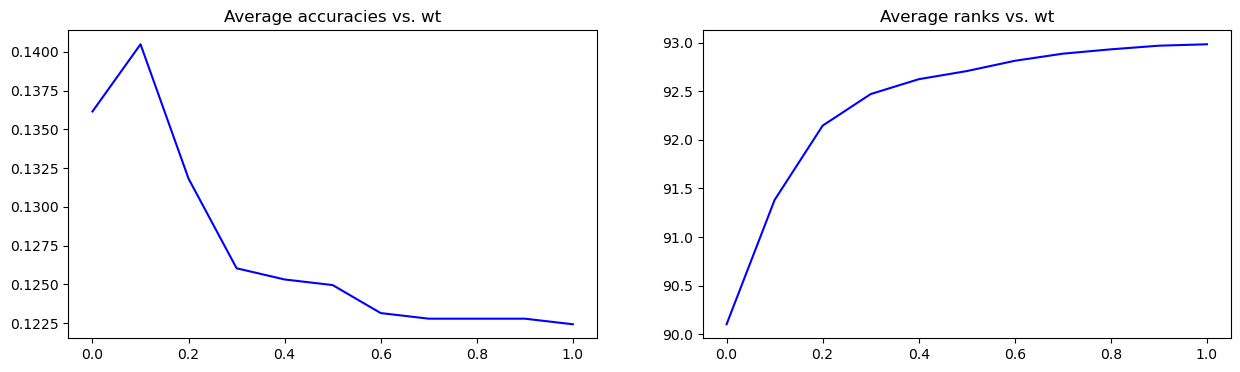

In [34]:
wt = [0.1*i for i in range(11)]
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(wt, accuracies, 'b')
plt.title('Average accuracies vs. wt')

plt.subplot(122)
plt.plot(wt, ranks, 'b')
plt.title('Average ranks vs. wt')

plt.show()

In [35]:
accuracies = []
ranks = []
for i in range(8):
    wt = 0.02 * i
    print(f"=== Evaluating model with wt={wt:.2f} ===")
    val_pred = model(val_query, wt)
    acc_, rank_ = evaluate(val_pred, val_truth)
    accuracies.append(acc_)
    ranks.append(rank_)
    print("")

=== Evaluating model with wt=0.00 ===


100%|██████████| 2769/2769 [02:00<00:00, 23.05it/s]


Average accuracy in the validation set: 0.13615023474178403
Average rank in the validation set:     90.10111953773925

=== Evaluating model with wt=0.02 ===


100%|██████████| 2769/2769 [02:05<00:00, 22.14it/s]


Average accuracy in the validation set: 0.18273745034308414
Average rank in the validation set:     87.79920548934633

=== Evaluating model with wt=0.04 ===


100%|██████████| 2769/2769 [02:07<00:00, 21.78it/s]


Average accuracy in the validation set: 0.15745756590827015
Average rank in the validation set:     89.61466233297219

=== Evaluating model with wt=0.06 ===


100%|██████████| 2769/2769 [02:08<00:00, 21.50it/s]


Average accuracy in the validation set: 0.1469844709281329
Average rank in the validation set:     90.5774647887324

=== Evaluating model with wt=0.08 ===


100%|██████████| 2769/2769 [02:14<00:00, 20.64it/s]


Average accuracy in the validation set: 0.14373420007222823
Average rank in the validation set:     91.05669916937522

=== Evaluating model with wt=0.10 ===


100%|██████████| 2769/2769 [02:07<00:00, 21.69it/s]


Average accuracy in the validation set: 0.14048392921632358
Average rank in the validation set:     91.38100397255327

=== Evaluating model with wt=0.12 ===


100%|██████████| 2769/2769 [02:04<00:00, 22.19it/s]


Average accuracy in the validation set: 0.13759479956663057
Average rank in the validation set:     91.65402672444925

=== Evaluating model with wt=0.14 ===


100%|██████████| 2769/2769 [02:05<00:00, 22.14it/s]

Average accuracy in the validation set: 0.13434452871072589
Average rank in the validation set:     91.8169014084507



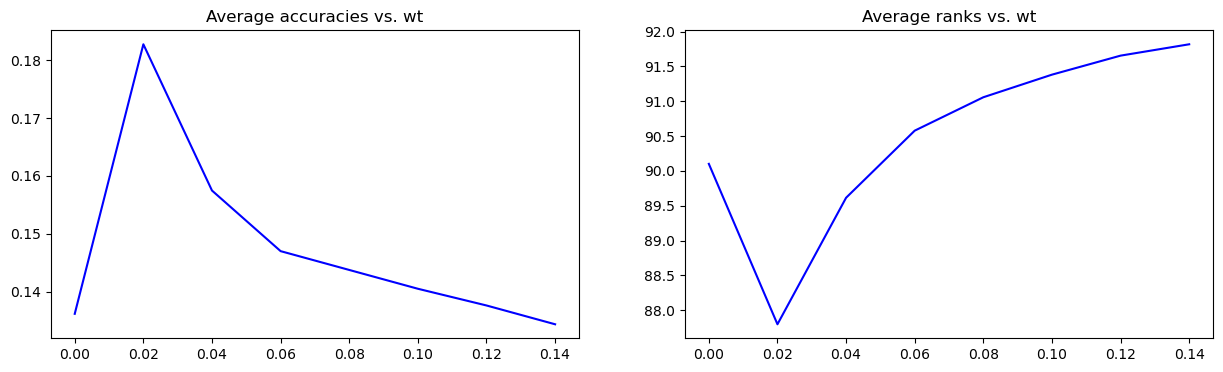

In [36]:
wt = [0.02*i for i in range(8)]
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(wt, accuracies, 'b')
plt.title('Average accuracies vs. wt')

plt.subplot(122)
plt.plot(wt, ranks, 'b')
plt.title('Average ranks vs. wt')

plt.show()

#### Step 5-1-2. With frequent items

In [37]:
print(f"=== Evaluating model with frequent items ===")
val_pred = model(val_query, frequent=True)
acc_, rank_ = evaluate(val_pred, val_truth)

=== Evaluating model with frequent items ===


100%|██████████| 2769/2769 [00:57<00:00, 48.31it/s]

Average accuracy in the validation set: 0.16648609606356085
Average rank in the validation set:     88.74395088479595


### Step 5-2. Linear combination of itemset-itemset (```train```) + user-user (```ui```) collaborative filtering

In [ ]:
# get the similarity of users to the itemset foo
def ui_similarity(foo, wt=0, rt=1):
    sims = []
    for i in ui.keys():
        sim = similarity(foo, ui[i]) + wt
        sims.append((i, sim * (1-rt)))
    return sims

In [28]:
# predicts the 100 most probable missing item in each itemset in dest_query
def model_ui(dest_query, wt=0, rt=1):
    dest_pred = {}
    # for each itemset in dest_query
    for i in tqdm(dest_query.keys()):
        iter = dest_query[i]
        # sort the itemsets in train and ui in the order of similarity to the itemset
        sims = most_similar(iter, wt)
        sims = [(elem[0], elem[1] * rt) for elem in sims]
        sims_ = ui_similarity(iter, wt, rt)
        candidates = {}
        # for each itemset in sims
        for j in range(len(sims)):
            iter_ = train[sims[j][0]]
            sim_ = sims[j][1]
            # append each item in it together with the similarity of this sims itemset to the dest_query itemset of interest
            for k in range(len(iter_)):
                # only if this item is not already in the dest_query itemset itself
                if iter_[k] not in iter:
                    try:
                        candidates[iter_[k]] += sim_
                    except:
                        candidates[iter_[k]] = sim_
        # for each user in sims_
        for j in range(len(sims_)):
            iter_ = ui[sims_[j][0]]
            sim_ = sims_[j][1]
            # append each item in it together with the similarity of this sims_ itemset to the dest_query itemset of interest
            for k in range(len(iter_)):
                # only if this item is not already in the dest_query itemset itself
                if iter_[k] not in iter:
                    try:
                        candidates[iter_[k]] += sim_
                    except:
                        candidates[iter_[k]] = sim_
        # sort the candidates in descending order of the accumulated similarity and take the first 100, append to the prediction dictionary
        candidates = sorted(candidates.items(), key=lambda x:x[1], reverse=True)
        candidates = [elem[0] for elem in candidates][:100]
        if len(candidates) < 100:
            print(f"Oops! The number candidates for {i} is less than 100.")
        dest_pred[i] = candidates
    return dest_pred

In [21]:
accuracies = []
ranks = []
wt = 0.02
for i in range(6):
    rt = 0.2 * i
    print(f"=== Evaluating model with wt={wt:.2f} and rt={rt:.2f} ===")
    val_pred = model_ui(val_query, wt, rt)
    acc_, rank_ = evaluate(val_pred, val_truth)
    accuracies.append(acc_)
    ranks.append(rank_)
    print("")

=== Evaluating model with wt=0.02 and rt=0.00 ===


100%|██████████| 2769/2769 [28:10<00:00,  1.64it/s]


Average accuracy in the validation set: 0.10653665583243048
Average rank in the validation set:     93.90863127482845

=== Evaluating model with wt=0.02 and rt=0.20 ===


100%|██████████| 2769/2769 [28:15<00:00,  1.63it/s]


Average accuracy in the validation set: 0.10834236186348863
Average rank in the validation set:     93.81581798483207

=== Evaluating model with wt=0.02 and rt=0.40 ===


100%|██████████| 2769/2769 [28:13<00:00,  1.63it/s]


Average accuracy in the validation set: 0.10906464427591188
Average rank in the validation set:     93.67786204405922

=== Evaluating model with wt=0.02 and rt=0.60 ===


100%|██████████| 2769/2769 [28:09<00:00,  1.64it/s]


Average accuracy in the validation set: 0.11375947995666305
Average rank in the validation set:     93.40592271578187

=== Evaluating model with wt=0.02 and rt=0.80 ===


100%|██████████| 2769/2769 [28:06<00:00,  1.64it/s]


Average accuracy in the validation set: 0.1292885518237631
Average rank in the validation set:     92.39906103286386

=== Evaluating model with wt=0.02 and rt=1.00 ===


100%|██████████| 2769/2769 [28:08<00:00,  1.64it/s]

Average accuracy in the validation set: 0.18273745034308414
Average rank in the validation set:     87.79920548934633



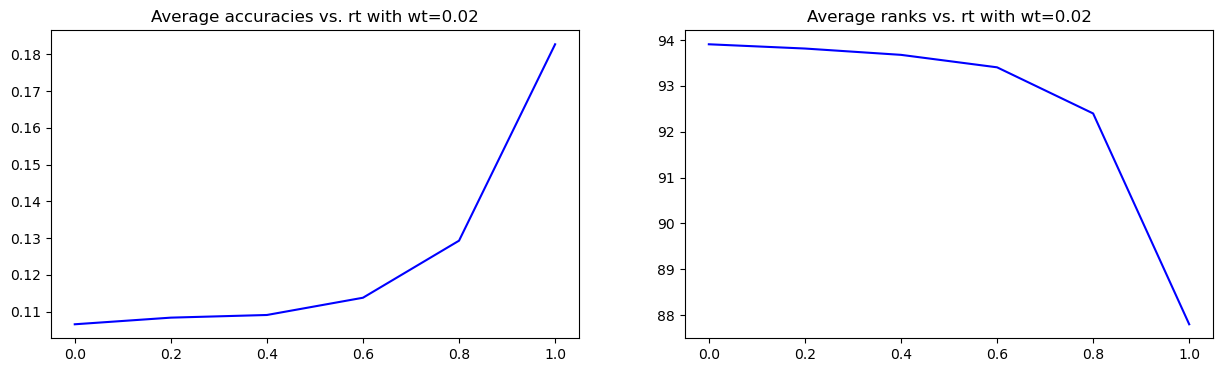

In [22]:
rt = [0.2*i for i in range(6)]
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(rt, accuracies, 'b')
plt.title(f'Average accuracies vs. rt with wt={wt:.2f}')

plt.subplot(122)
plt.plot(rt, ranks, 'b')
plt.title(f'Average ranks vs. rt with wt={wt:.2f}')

plt.show()

## Step 6. Approach 2: Neighbor Mining
<b>Best result: wt=0.04</b>  
Average accuracy: 0.24846514987360058  
Average rank:     82.56193571686529

In [15]:
def neighbor(data):
    neighbors = defaultdict(dict)
    # for each foo=itemset#, boo=items in foo
    for foo, boo in tqdm(data.items()):
        # for each item in boo
        for elem in boo:
            # list of items excluding elem
            boo_ = [i for i in boo if i != elem]
            # add the count of items neighboring elem to the neighbors[elem][neighbor item#]
            for iter in boo_:
                try:
                    neighbors[elem][iter] += 1
                except:
                    neighbors[elem][iter] = 1
    return neighbors #dictionary of key=item# and value=(dictionary of key=neighboring_item#, value=occurrence_count)

In [16]:
neighbors = neighbor(train)
ui_neighbors = neighbor(ui)

100%|██████████| 53843/53843 [00:40<00:00, 1333.00it/s]


In [17]:
# get the items in the train data 
items = {}
for i in train.keys():
    iter = train[i]
    for elem in iter:
        try:
            items[elem] += 1
        except:
            items[elem] = 1

items_ = [elem[0] for elem in items.items()]

# sort items based on their frequency in the train data (descending order)
frequents = sorted(items.items(), key=lambda x:x[1], reverse=True)
frequents = [elem[0] for elem in frequents]

In [18]:
def knn(query, ui=False, wt=0.0):
    prediction = defaultdict(dict)

    print("Getting neighbors...")
    # for each foo=itemset#, boo=list of items
    for foo, boo in tqdm(query.items()):
        # for each elem of boo:
        for elem in boo:
            # for each foo_=(item# neighboring boo in neighbors), boo_=(occurrences of neighboring in neighbors)
            # add the boo_ to prediction[itemset#][candidate_neighbor_item#]
            for foo_, boo_ in neighbors[elem].items():
                try:
                    prediction[foo][foo_] += boo_ 
                except:
                    prediction[foo][foo_] = boo_
            if ui:
                for foo_, boo_ in ui_neighbors[elem].items():
                    try:
                        prediction[foo][foo_] += boo_ * wt
                    except:
                        prediction[foo][foo_] = boo_ * wt
    
    print("Removing items already in the itemset...")
    # remove candidate item if it is already in the itemset
    for foo, boo in tqdm(prediction.items()):
        remove = []
        for foo_, boo_ in boo.items():
            if foo_ in query[foo]:
                remove.append(foo_)
        for elem in remove:
            prediction[foo].pop(elem)

    # sort in descending order based on the # of occurrence, remove the # of occurrence
    prediction = [(foo, boo.items()) for foo, boo in prediction.items()]
    prediction = [(foo, sorted(boo, reverse=True, key=lambda x:x[1])) for foo, boo in prediction]
    prediction = [(foo, [elem[0] for elem in boo]) for foo, boo in prediction]

    print("Adding frequent items and finalizing results...")    
    # add frequent items
    predictions = {}
    for foo, boo in tqdm(prediction):
        good = set(frequents).difference(boo).difference(query[foo])
        predictions[foo] = (boo + [elem for elem in frequents if elem in good])[:100]
        assert len(predictions[foo]) == 100

    return predictions

### Step 6-1. Neighbor Mining with ```train``` dataset

In [ ]:
val_pred = knn(val_query)

Getting neighbors...


100%|██████████| 2769/2769 [00:00<00:00, 7880.19it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:00<00:00, 8290.18it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:36<00:00, 76.56it/s]


In [ ]:
# evaluate model
evaluate(val_pred, val_truth)

Average accuracy in the validation set: 0.16756951968219574
Average rank in the validation set:     88.60960635608522


(0.16756951968219574, 88.60960635608522)

### Step 6-2. Neighbor Mining with ```train``` and ```ui``` datasets

In [ ]:
accuracies = []
ranks = []
for i in range(11):
    wt = 0.1 * i
    print(f"=== Evaluating model with wt={wt:.2f} ===")
    val_pred = knn(val_query, ui=True, wt=wt)
    acc_, rank_ = evaluate(val_pred, val_truth)
    accuracies.append(acc_)
    ranks.append(rank_)
    print("")

=== Evaluating model with wt=0.00 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:34<00:00, 79.42it/s] 


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:06<00:00, 408.12it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:43<00:00, 64.03it/s]


Average accuracy in the validation set: 0.1621524015890213
Average rank in the validation set:     88.60130010834236

=== Evaluating model with wt=0.10 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:28<00:00, 95.88it/s] 


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:07<00:00, 373.26it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:49<00:00, 55.46it/s]


Average accuracy in the validation set: 0.24232574936800289
Average rank in the validation set:     83.11664860960636

=== Evaluating model with wt=0.20 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:30<00:00, 91.41it/s] 


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:05<00:00, 484.25it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:42<00:00, 64.81it/s]


Average accuracy in the validation set: 0.2322137955940773
Average rank in the validation set:     84.11448176236908

=== Evaluating model with wt=0.30 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:30<00:00, 91.84it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:07<00:00, 388.62it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:43<00:00, 64.27it/s]


Average accuracy in the validation set: 0.22282412423257494
Average rank in the validation set:     84.74792343806428

=== Evaluating model with wt=0.40 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:29<00:00, 93.31it/s] 


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:05<00:00, 476.23it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:50<00:00, 55.04it/s]


Average accuracy in the validation set: 0.21776814734561215
Average rank in the validation set:     85.17768147345612

=== Evaluating model with wt=0.50 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:28<00:00, 96.58it/s] 


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:06<00:00, 440.39it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:45<00:00, 60.50it/s]


Average accuracy in the validation set: 0.21307331166486096
Average rank in the validation set:     85.3355001805706

=== Evaluating model with wt=0.60 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:28<00:00, 97.28it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:06<00:00, 437.28it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:39<00:00, 69.77it/s]


Average accuracy in the validation set: 0.2109064644275912
Average rank in the validation set:     85.58468761285663

=== Evaluating model with wt=0.70 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:28<00:00, 96.34it/s] 


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:05<00:00, 479.98it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:46<00:00, 59.95it/s]


Average accuracy in the validation set: 0.2098230408089563
Average rank in the validation set:     85.7612856626941

=== Evaluating model with wt=0.80 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:29<00:00, 93.16it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:06<00:00, 419.61it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:42<00:00, 65.92it/s]


Average accuracy in the validation set: 0.20837847598410977
Average rank in the validation set:     85.85951607078367

=== Evaluating model with wt=0.90 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:45<00:00, 60.31it/s] 


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:08<00:00, 337.27it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:43<00:00, 63.22it/s]


Average accuracy in the validation set: 0.20693391115926327
Average rank in the validation set:     85.90213073311665

=== Evaluating model with wt=1.00 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:30<00:00, 89.52it/s] 


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:08<00:00, 328.65it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:41<00:00, 67.34it/s]


Average accuracy in the validation set: 0.20548934633441676
Average rank in the validation set:     85.96063560852294



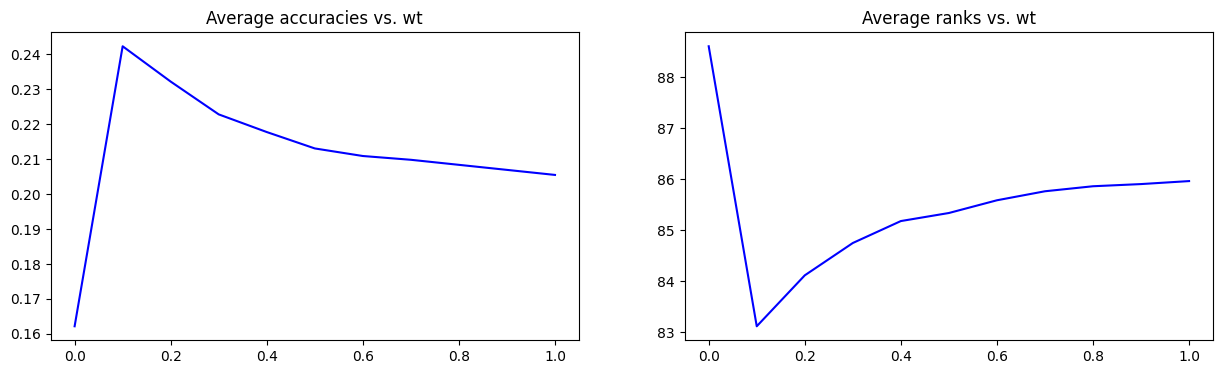

In [ ]:
wt = [0.1*i for i in range(11)]
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(wt, accuracies, 'b')
plt.title(f'Average accuracies vs. wt')

plt.subplot(122)
plt.plot(wt, ranks, 'b')
plt.title(f'Average ranks vs. wt')

plt.show()

In [ ]:
accuracies = []
ranks = []
for i in range(11):
    wt = 0.02 * i
    print(f"=== Evaluating model with wt={wt:.3f} ===")
    val_pred = knn(val_query, ui=True, wt=wt)
    acc_, rank_ = evaluate(val_pred, val_truth)
    accuracies.append(acc_)
    ranks.append(rank_)
    print("")

=== Evaluating model with wt=0.000 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:34<00:00, 81.38it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:06<00:00, 424.54it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [01:03<00:00, 43.52it/s]


Average accuracy in the validation set: 0.1621524015890213
Average rank in the validation set:     88.60130010834236

=== Evaluating model with wt=0.020 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:33<00:00, 83.48it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:05<00:00, 468.92it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:37<00:00, 73.63it/s]


Average accuracy in the validation set: 0.24521487901769592
Average rank in the validation set:     82.81617912603828

=== Evaluating model with wt=0.040 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:27<00:00, 101.49it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:06<00:00, 422.36it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:35<00:00, 78.84it/s]


Average accuracy in the validation set: 0.24846514987360058
Average rank in the validation set:     82.56193571686529

=== Evaluating model with wt=0.060 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:27<00:00, 102.16it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:05<00:00, 483.99it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:34<00:00, 81.36it/s]


Average accuracy in the validation set: 0.24593716143011918
Average rank in the validation set:     82.80498374864572

=== Evaluating model with wt=0.080 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:27<00:00, 101.52it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:08<00:00, 315.20it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:36<00:00, 75.64it/s]


Average accuracy in the validation set: 0.24015890213073313
Average rank in the validation set:     82.97977609245216

=== Evaluating model with wt=0.100 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:27<00:00, 101.74it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:05<00:00, 484.68it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:37<00:00, 74.00it/s]


Average accuracy in the validation set: 0.24232574936800289
Average rank in the validation set:     83.11664860960636

=== Evaluating model with wt=0.120 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:27<00:00, 101.31it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:05<00:00, 478.32it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:40<00:00, 68.25it/s]


Average accuracy in the validation set: 0.24088118454315638
Average rank in the validation set:     83.34525099313832

=== Evaluating model with wt=0.140 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:27<00:00, 100.79it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:05<00:00, 478.01it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:35<00:00, 78.70it/s]


Average accuracy in the validation set: 0.23943661971830985
Average rank in the validation set:     83.51354279523294

=== Evaluating model with wt=0.160 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:26<00:00, 103.67it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:07<00:00, 369.01it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:37<00:00, 74.12it/s]


Average accuracy in the validation set: 0.2372697724810401
Average rank in the validation set:     83.7547851209823

=== Evaluating model with wt=0.180 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:27<00:00, 101.23it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:07<00:00, 367.98it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:39<00:00, 69.58it/s]


Average accuracy in the validation set: 0.23510292524377033
Average rank in the validation set:     83.96027446731672

=== Evaluating model with wt=0.200 ===
Getting neighbors...


100%|██████████| 2769/2769 [00:27<00:00, 101.27it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:07<00:00, 370.38it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:35<00:00, 78.29it/s]


Average accuracy in the validation set: 0.2322137955940773
Average rank in the validation set:     84.11448176236908



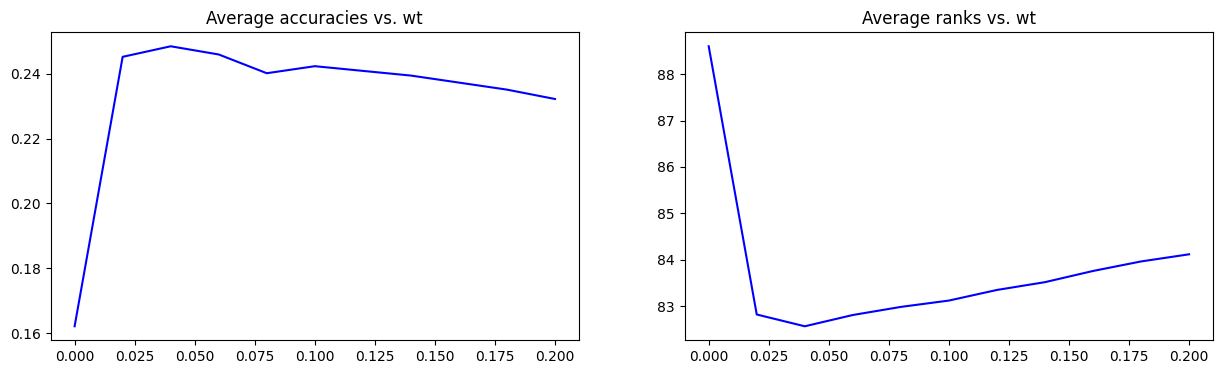

In [ ]:
wt = [0.02*i for i in range(11)]
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(wt, accuracies, 'b')
plt.title(f'Average accuracies vs. wt')

plt.subplot(122)
plt.plot(wt, ranks, 'b')
plt.title(f'Average ranks vs. wt')

plt.show()

## Step 7. Approach 3: Item-item collaborative filtering
<b>Best result: ratio=0.96</b>  
Average accuracy: 0.24774286746117732  
Average rank:     82.61646803900325

In [43]:
def transpose(data):
    trans = defaultdict(list)
    for foo, boo in data.items():
        for elem in boo: 
            trans[elem].append(foo)
    return trans

In [16]:
# calculate the similarity between two items, foo and boo
def similarity(foo, boo):
    sim = len(set(foo).intersection(boo))
    return sim

In [17]:
# sort the items in data in the order of similarity to the item foo
def most_similar(idx, data, ref, len_=-1):
    sims = []
    for i in set(ref).difference({idx}):
        sim = similarity(data[idx], data[i])
        if len_ == -1 or sim>=len_:
            sims.append((i, sim))
    sims.sort(key=lambda x:x[1], reverse=True)
    return sims

In [18]:
# sort the items in data in the order of similarity to the item foo
def ui_most_similar(idx, data, ref, len_=-1):
    sims = []
    for i in set(ref).difference({idx}):
        if idx in data.keys() and i in data.keys():
            sim = similarity(data[idx], data[i])
            if len_ == -1 or sim>=len_:
                sims.append((i, sim))
    sims.sort(key=lambda x:x[1], reverse=True)
    return sims

In [19]:
# get the items in the train data 
items = {}
for i in train.keys():
    iter = train[i]
    for elem in iter:
        try:
            items[elem] += 1
        except:
            items[elem] = 1

items_ = [elem[0] for elem in items.items()]

# sort items based on their frequency in the train data (descending order)
frequents = sorted(items.items(), key=lambda x:x[1], reverse=True)
frequents = [elem[0] for elem in frequents]

In [20]:
# predicts the 100 most probable missing item in each itemset in dest_query
def model(dest_query, combine=False, ratio=1.0, len_=-1):
    dest_pred = defaultdict(dict)
    train_ = transpose(train)
    ui_ = transpose(ui)
    # for each itemset in dest_query
    for i in tqdm(dest_query.keys()):
        dest_pred[i] = dict()
        for idx in train_.keys():
            sims = most_similar(idx, train_, dest_query[i], len_=len_)
            for foo_, boo_ in sims:
                try:
                    dest_pred[i][idx] += boo_ * ratio
                except:
                    dest_pred[i][idx] = boo_ * ratio
        if combine:
            for idx in ui_.keys():
                sims = ui_most_similar(idx, ui_, dest_query[i], len_=len_)
                for foo_, boo_ in sims:
                    try:
                        dest_pred[i][idx] += boo_ * (1.0 - ratio)
                    except:
                        dest_pred[i][idx] = boo_ * (1.0 - ratio)

    dest_pred = [(foo, boo.items()) for foo, boo in dest_pred.items()]
    dest_pred = [(foo, sorted(boo, reverse=True, key=lambda x:x[1])[:120]) for foo, boo in dest_pred]
    dest_pred = [(foo, [elem[0] for elem in boo]) for foo, boo in dest_pred]
    dest_pred = [(foo, [elem for elem in boo if elem not in dest_query[foo]][:100]) for foo, boo in dest_pred]
    for i in range(len(dest_pred)):
        if len(dest_pred[i][1]) < 100:
            good = set(frequents).difference(dest_pred[i][1]).difference(dest_query[dest_pred[i][0]])
            dest_pred[i] = (dest_pred[i][0], list(dest_pred[i][1] + list(good))[:100])
            #if len(dest_pred[i][1]) != 100:
            #    print("Warning! Too little matches.")

    pred = {}
    for foo, boo in dest_pred:
        assert len(boo) == 100
        pred[foo] = boo
    return pred

### Step 7-1. Item-item collaborative filtering with ```train``` dataset

#### Step 7-1-1. Without similar item restriction

In [21]:
val_pred = model(val_query)
acc_, rank_ = evaluate(val_pred, val_truth)

100%|██████████| 2769/2769 [03:46<00:00, 12.24it/s]


Average accuracy in the validation set: 0.14590104730949802
Average rank in the validation set:     89.14156735283495


#### Step 7-1-2. With similar item restriction

In [109]:
accuracies = []
ranks = []
for i in range(11):
    len_ = i
    print(f"=== Evaluating model with len_={len_} ===")
    val_pred = model(val_query, len_=len_)
    acc_, rank_ = evaluate(val_pred, val_truth)
    accuracies.append(acc_)
    ranks.append(rank_)
    print("")

=== Evaluating model with len_=0 ===


100%|██████████| 2769/2769 [12:07<00:00,  3.81it/s]


Average accuracy in the validation set: 0.14590104730949802
Average rank in the validation set:     89.14156735283495

=== Evaluating model with len_=1 ===


100%|██████████| 2769/2769 [08:32<00:00,  5.40it/s]


Average accuracy in the validation set: 0.14228963524738172
Average rank in the validation set:     89.27771758757675

=== Evaluating model with len_=2 ===


100%|██████████| 2769/2769 [08:24<00:00,  5.49it/s]


Average accuracy in the validation set: 0.04911520404478151
Average rank in the validation set:     96.32249909714699

=== Evaluating model with len_=3 ===


100%|██████████| 2769/2769 [08:31<00:00,  5.41it/s]


Average accuracy in the validation set: 0.03178042614662333
Average rank in the validation set:     97.94366197183099

=== Evaluating model with len_=4 ===


100%|██████████| 2769/2769 [08:37<00:00,  5.35it/s]


Average accuracy in the validation set: 0.024557602022390754
Average rank in the validation set:     98.63560852293247

=== Evaluating model with len_=5 ===


100%|██████████| 2769/2769 [08:37<00:00,  5.36it/s]


Average accuracy in the validation set: 0.018779342723004695
Average rank in the validation set:     99.19068255687974

=== Evaluating model with len_=6 ===


100%|██████████| 2769/2769 [08:42<00:00,  5.30it/s]


Average accuracy in the validation set: 0.013362224629830263
Average rank in the validation set:     99.72444925966053

=== Evaluating model with len_=7 ===


100%|██████████| 2769/2769 [08:37<00:00,  5.35it/s]


Average accuracy in the validation set: 0.010473094980137234
Average rank in the validation set:     100.01083423618635

=== Evaluating model with len_=8 ===


100%|██████████| 2769/2769 [08:37<00:00,  5.35it/s]


Average accuracy in the validation set: 0.009389671361502348
Average rank in the validation set:     100.11881545684362

=== Evaluating model with len_=9 ===


100%|██████████| 2769/2769 [08:33<00:00,  5.39it/s]


Average accuracy in the validation set: 0.008306247742867461
Average rank in the validation set:     100.22571325388226

=== Evaluating model with len_=10 ===


100%|██████████| 2769/2769 [08:32<00:00,  5.41it/s]


Average accuracy in the validation set: 0.008306247742867461
Average rank in the validation set:     100.22571325388226



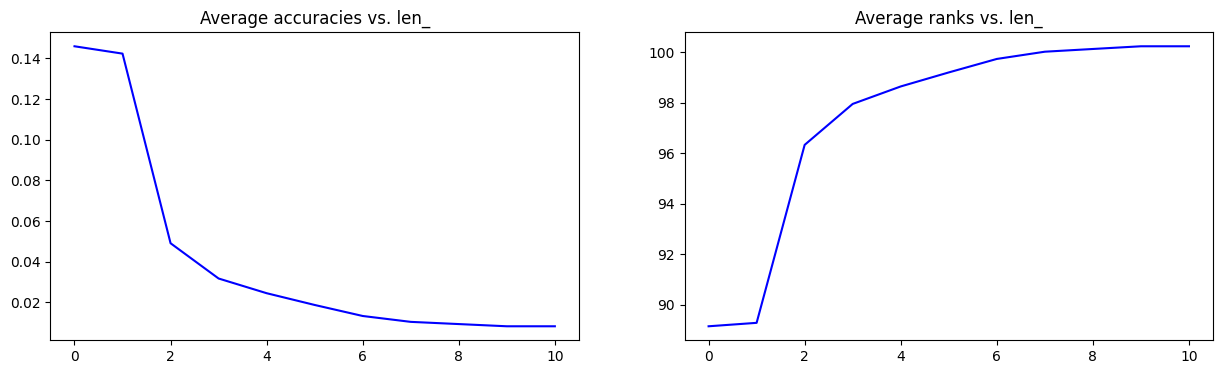

In [110]:
len_ = [i for i in range(11)]
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(len_, accuracies, 'b')
plt.title('Average accuracies vs. len_')

plt.subplot(122)
plt.plot(len_, ranks, 'b')
plt.title('Average ranks vs. len_')

plt.show()

### Step 7-2. Item-item collaborative filtering with ```train``` and ```ui``` datasets

In [22]:
accuracies = []
ranks = []
for i in range(11):
    ratio = 0.1 * i
    print(f"=== Evaluating model with ratio={ratio:.1f} ===")
    val_pred = model(val_query, combine=True, ratio=ratio)
    acc_, rank_ = evaluate(val_pred, val_truth)
    accuracies.append(acc_)
    ranks.append(rank_)
    print("")

=== Evaluating model with ratio=0.0 ===


100%|██████████| 2769/2769 [27:11<00:00,  1.70it/s]


Average accuracy in the validation set: 0.19754423979776092
Average rank in the validation set:     86.72083784759842

=== Evaluating model with ratio=0.1 ===


100%|██████████| 2769/2769 [27:11<00:00,  1.70it/s]


Average accuracy in the validation set: 0.1997110870350307
Average rank in the validation set:     86.5745756590827

=== Evaluating model with ratio=0.2 ===


100%|██████████| 2769/2769 [27:32<00:00,  1.68it/s]


Average accuracy in the validation set: 0.20007222824124232
Average rank in the validation set:     86.56193571686529

=== Evaluating model with ratio=0.3 ===


100%|██████████| 2769/2769 [29:58<00:00,  1.54it/s]


Average accuracy in the validation set: 0.20043336944745396
Average rank in the validation set:     86.5250993138317

=== Evaluating model with ratio=0.4 ===


100%|██████████| 2769/2769 [29:25<00:00,  1.57it/s]


Average accuracy in the validation set: 0.20332249909714697
Average rank in the validation set:     86.40917298663777

=== Evaluating model with ratio=0.5 ===


100%|██████████| 2769/2769 [27:32<00:00,  1.68it/s]


Average accuracy in the validation set: 0.20657276995305165
Average rank in the validation set:     86.12026002166847

=== Evaluating model with ratio=0.6 ===


100%|██████████| 2769/2769 [27:33<00:00,  1.67it/s]


Average accuracy in the validation set: 0.2109064644275912
Average rank in the validation set:     85.6984470928133

=== Evaluating model with ratio=0.7 ===


100%|██████████| 2769/2769 [27:43<00:00,  1.66it/s]


Average accuracy in the validation set: 0.21668472372697725
Average rank in the validation set:     85.31888768508487

=== Evaluating model with ratio=0.8 ===


100%|██████████| 2769/2769 [27:09<00:00,  1.70it/s]


Average accuracy in the validation set: 0.22824124232574936
Average rank in the validation set:     84.49512459371614

=== Evaluating model with ratio=0.9 ===


100%|██████████| 2769/2769 [27:05<00:00,  1.70it/s]


Average accuracy in the validation set: 0.24088118454315638
Average rank in the validation set:     83.27591188154568

=== Evaluating model with ratio=1.0 ===


100%|██████████| 2769/2769 [27:07<00:00,  1.70it/s]


Average accuracy in the validation set: 0.14590104730949802
Average rank in the validation set:     89.14156735283495



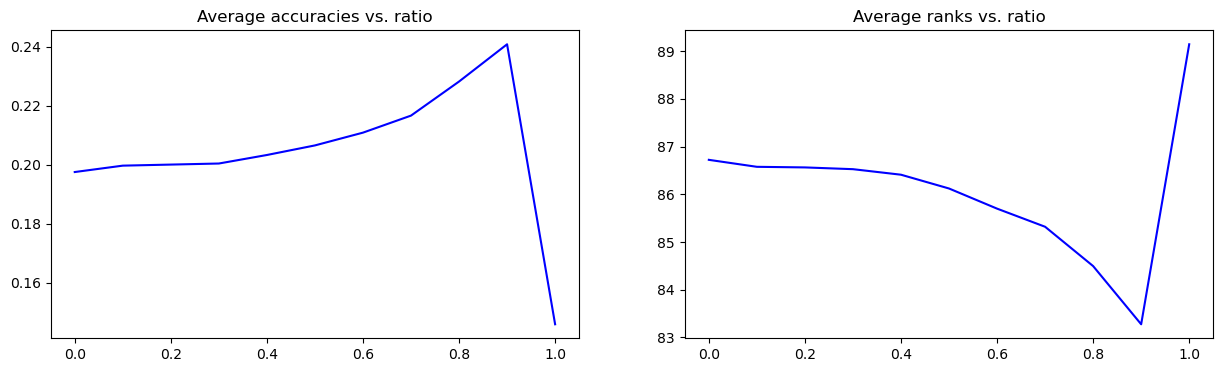

In [23]:
ratio = [0.1*i for i in range(11)]
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(ratio, accuracies, 'b')
plt.title('Average accuracies vs. ratio')

plt.subplot(122)
plt.plot(ratio, ranks, 'b')
plt.title('Average ranks vs. ratio')

plt.show()

In [26]:
accuracies = []
ranks = []
for i in range(1,5):
    ratio = 0.9 + 0.02 * i
    print(f"=== Evaluating model with ratio={ratio:.2f} ===")
    val_pred = model(val_query, combine=True, ratio=ratio)
    acc_, rank_ = evaluate(val_pred, val_truth)
    accuracies.append(acc_)
    ranks.append(rank_)
    print("")

=== Evaluating model with ratio=0.92 ===


100%|██████████| 2769/2769 [27:45<00:00,  1.66it/s]


Average accuracy in the validation set: 0.24160346695557963
Average rank in the validation set:     83.07836764174792

=== Evaluating model with ratio=0.94 ===


100%|██████████| 2769/2769 [28:11<00:00,  1.64it/s]


Average accuracy in the validation set: 0.24413145539906103
Average rank in the validation set:     82.87721198988805

=== Evaluating model with ratio=0.96 ===


100%|██████████| 2769/2769 [28:10<00:00,  1.64it/s]


Average accuracy in the validation set: 0.24774286746117732
Average rank in the validation set:     82.61646803900325

=== Evaluating model with ratio=0.98 ===


100%|██████████| 2769/2769 [28:13<00:00,  1.64it/s]


Average accuracy in the validation set: 0.24593716143011918
Average rank in the validation set:     82.79198266522211



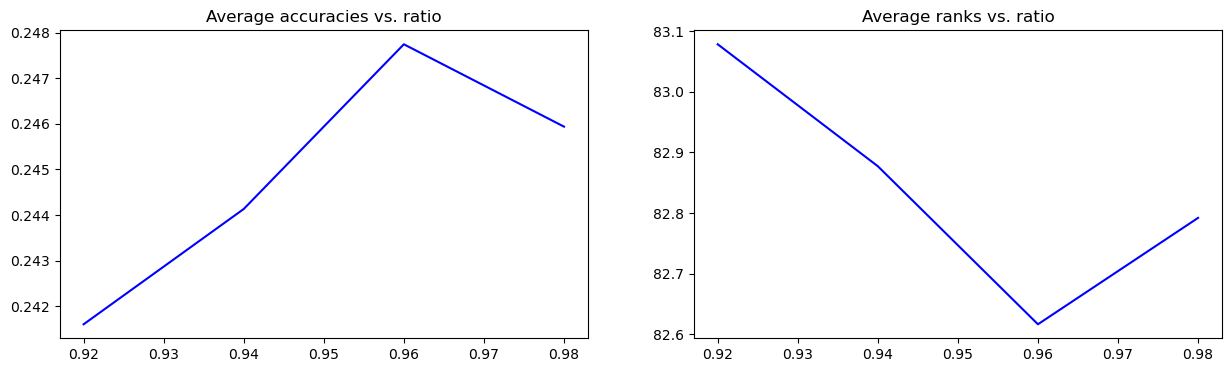

In [27]:
ratio = [0.9 + 0.02 * i for i in range(1,5)]
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.plot(ratio, accuracies, 'b')
plt.title('Average accuracies vs. ratio')

plt.subplot(122)
plt.plot(ratio, ranks, 'b')
plt.title('Average ranks vs. ratio')

plt.show()

## Step 8. Finding the 100 most probable fashion items of test queries using Neighbor Mining with wt=0.04
For each query of incomplete outfits in ```itemset_item_test_query.csv```, we write the 100 most probable fashion items in ```itemset_item_test_prediction.csv```. Specifically, we write 101 values separated by commas where each line consists of ```itemset_id``` + comma + 100 ```item_id``` candidates (sorted in descending order based on the probability of being the missing item) which are separated by a comma.

### Step 8-1. Processing test queries

In [19]:
val_pred = knn(val_query, ui=True, wt=0.04)
acc_, rank_ = evaluate(val_pred, val_truth)

Getting neighbors...


100%|██████████| 2769/2769 [00:08<00:00, 326.50it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:02<00:00, 1208.89it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:08<00:00, 340.99it/s]


Average accuracy in the validation set: 0.24846514987360058
Average rank in the validation set:     82.56193571686529


In [20]:
test_pred = knn(test_query, ui=True, wt=0.04)

Getting neighbors...


100%|██████████| 2769/2769 [00:08<00:00, 311.04it/s]


Removing items already in the itemset...


100%|██████████| 2769/2769 [00:02<00:00, 1280.07it/s]


Adding frequent items and finalizing results...


100%|██████████| 2769/2769 [00:08<00:00, 319.46it/s]


### Step 8-2. Mounting the answers for test queries to ```itemset_item_test_prediction.csv```

In [21]:
import csv

cnt = 0
with open("./result/itemset_item_test_prediction.csv", "w") as f:
    writer = csv.writer(f)
    for foo, boo in zip(test_pred.keys(), test_pred.values()):
        prediction = (foo, *boo)
        writer.writerow(prediction)
        cnt += 1

In [22]:
if cnt == 2769 and len(test_pred) == 2769:
    print("Test predictions mounted correctly.")

Test predictions mounted correctly.
